In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import axion_motion
import clock_work_axion
import model
import transport_equation
from common.rh_neutrino import calc_Gamma_a_SU2
from common.util import latex_exponential_notation, make_plot_path

In [25]:
def plot(ress, filename=None, m_a=None, H_inf=None, Gamma_phi=None, digits=1, fs=15):
    # create figure and subplots 
    fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(10,10), 
                                   gridspec_kw=dict(height_ratios=[1, 2]))
    fig.subplots_adjust(hspace=0)
        
    # plot the evolution of the asymmetry for both codes
    for i, res in enumerate(ress):        
        l1, = ax1.loglog(res.t, -transport_equation.calc_B_minus_L(res.red_chem_pots), 
                   color="black", label="asymmetry" if i == len(ress) - 1 else None)
                
    ax1.set_ylim(1e-15, 1e-7)
    ax1.set_ylabel(r"$\mu_{B - L} / T$", fontsize=15)
    
    # plot the source from the axion field on a second axis on the right
    ax_sec = ax1.twinx()
    for i, res in enumerate(ress):
        T = res.T_fn(res.t)
        theta, theta_dot = res.axion_fn(np.log(res.t))
        y = theta_dot / T / 1e-6
        l3, = ax_sec.semilogx(res.t, y, 
            label="source" if i == len(ress) - 1 else None, color="tab:blue")
        
    ax_sec.get_yaxis().get_major_formatter().set_useOffset(False)
    ax_sec.set_ylabel(r"$\dot{\theta} / T \cdot 10^{6}$", fontsize=fs)
    ax_sec.set_xscale("log")
    
    # legend for the main plot
    lines = [l1, l3]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper left", framealpha=1, fontsize=fs - 2) # loc="center left"
    
    # plot the temperature evolution in a second subfigure on the top
    for i, res in enumerate(ress):
        ax2.loglog(res.t, res.T_fn(res.t), color="tab:blue")
                
    ax1.set_xlabel(r"$t \cdot \mathrm{GeV}$", fontsize=15)
    ax2.set_ylabel(r"$T / \mathrm{GeV}$", fontsize=15)
    
    # added labels for the equilibration times
    ax2.xaxis.tick_top()
    T_max = max([np.max(res.T_fn(res.t)) for res in ress])
    T_min = min([np.min(res.T_fn(res.t)) for res in ress])
    t_eqs = []
    
    t_min_plot, t_max_plot = ax2.get_xlim()
    arrow_percent_dx = 0.03
    arrow_height = 0.3
    
    for alpha, T_eq in enumerate(model.T_eqs):
        if T_min > T_eq  or T_eq > T_max:
            continue
        for res in ress:
            try:
                res = root(lambda log_t: np.log(res.T_fn(np.exp(log_t)) / T_eq), 
                           (np.log(res.t[0]) + np.log(res.t[-1])) / 2
                )
                if res.success:
                    t_eq = np.exp(res.x[0])
                    t_eqs.append(t_eq)
                    ax2.axvline(t_eq, color="black", ls="--")
                    
                    s = np.sign(transport_equation.rate(2 * T_eq)[alpha] - transport_equation.rate(T_eq)[alpha])
                    percent = (np.log10(t_eq) - np.log10(t_min_plot)) / (np.log10(t_max_plot) - np.log10(t_min_plot))
                    ax2.annotate("", (percent + s * arrow_percent_dx, arrow_height), (percent, arrow_height), 
                                 xycoords="axes fraction", arrowprops=dict(arrowstyle="->"))
                    
                    break
            except Exception as e:
                print(e)
        else:
            t_eqs.append(None)
            
    good_names = [n for n, t_eq in zip(transport_equation.process_names, t_eqs) if t_eq is not None]
    good_t_eqs = [t_eq for t_eq in t_eqs if t_eq is not None]
    ax2.set_xticks(good_t_eqs)
    ax2.set_xticklabels(good_names, rotation=50, fontsize=fs)
    
    # add title with optionally given parameters 
    title_string = ""
    sep = r"\,\mathrm{GeV},\,"
    if m_a is not None:
        title_string += "m_a = " + latex_exponential_notation(m_a, digits) + sep
    if Gamma_phi is not None:
        title_string += r" \Gamma_\phi = " + latex_exponential_notation(Gamma_phi, digits) + sep
    if H_inf is not None:
        title_string += r" H_{\mathrm{inf}} = " + latex_exponential_notation(H_inf, digits) + sep
    title_string = title_string[:-3]
    if title_string:
        fig.suptitle(f"${title_string}$", fontsize=fs + 1, y=1.0002)
        
    ax1.tick_params(labelsize=fs)
    ax2.tick_params(labelsize=fs)
    ax_sec.tick_params(labelsize=fs)
    
    plt.tight_layout()
    # output of the figure
    if filename is not None:
        plt.savefig(make_plot_path(filename))
    plt.show()

In [3]:
def sim_and_plot(m_a, Gamma_phi, H_inf, filename=None, t_end=5e-5):
    m = model.AxionBaryogenesisModel(
        source_vector=transport_equation.source_vector_weak_sphaleron, 
        axion_rhs=axion_motion.axion_rhs_simple, calc_axion_mass=axion_motion.calc_const_axion_mass, 
        axion_initial=(1, 0), axion_parameter=(m_a,), 
        Gamma_phi=Gamma_phi, H_inf=H_inf)
    r = model.solve(m, collect=True, t_end=t_end)
    plot(r, filename, m_a=m_a, Gamma_phi=Gamma_phi, H_inf=H_inf)
    return m, r

In [4]:
H_inf = 2e10

<ipython-input-3-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


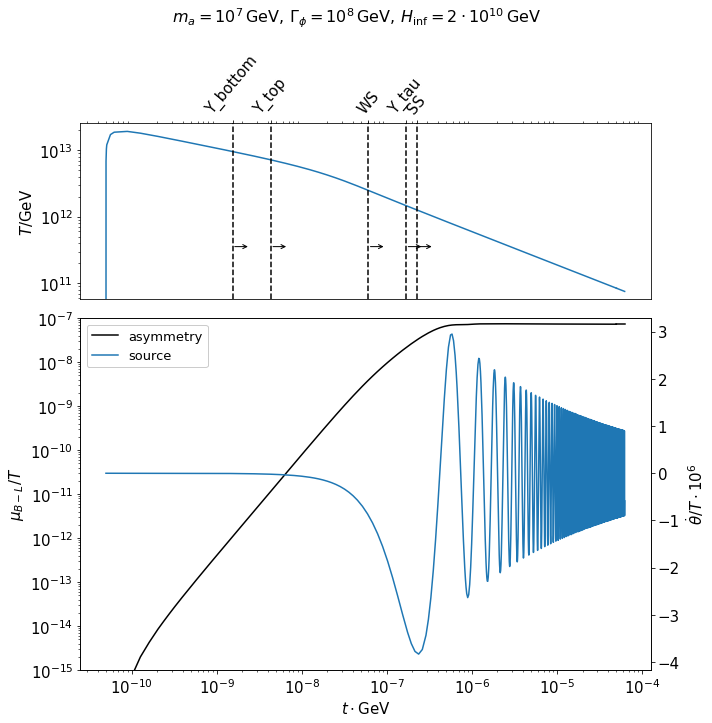

In [5]:
m, r = sim_and_plot(1e7, 1e8, H_inf, f_a) # , filename="evolution.pdf");

<ipython-input-3-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


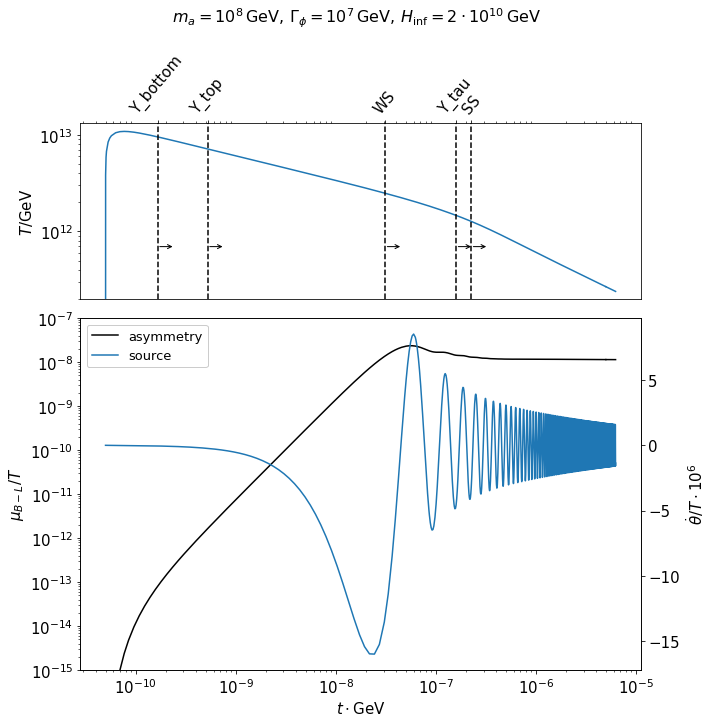

In [6]:
m2, r2 = sim_and_plot(1e8, 1e7, H_inf, f_a, t_end=5e-6)

In [27]:
def clockwork(mR, M, Gamma_phi, H_inf, filename=None, t_end=5e-5):
    m = model.AxionBaryogenesisModel(
        source_vector=transport_equation.source_vector_weak_sphaleron, 
        axion_rhs=clock_work_axion.clock_work_rhs, calc_axion_mass=clock_work_axion.clock_work_mass, 
        axion_initial=(1, 0), axion_parameter=(mR, M), 
        Gamma_phi=Gamma_phi, H_inf=H_inf)
    r = model.solve(m, collect=True, t_end=t_end, converge=False)
    plot(r, filename, m_a=clock_work_axion.clock_work_mass(0, mR, M), Gamma_phi=Gamma_phi, H_inf=H_inf)
    return m, r

In [8]:
Gamma_phi = 1e7
H_inf = 2e10
mR = 6

In [9]:
import reheating

In [17]:
t0, initial = reheating.calc_initial_reheating(H_inf)
tf = t0*1e7
T_fn, H_fn, T_dot_fn, final = reheating.solve_reheating_eq(t0, tf, initial, Gamma_phi)
M = 100 * 1e-9 / np.exp(- np.pi * mR)
print(M, "%e" % H_inf)
params = (mR, M)

15.35529353954466 2.000000e+10


In [18]:
sol = axion_motion.solve_axion_motion(clock_work_axion.clock_work_rhs, (1, 0), t0, tf, T_fn, H_fn, params, 1e-4)

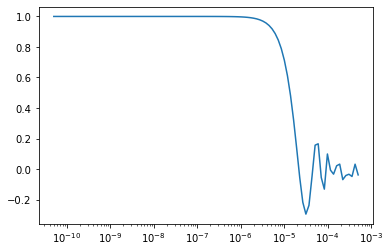

In [19]:
t_range = np.geomspace(t0, tf, 100)
plt.semilogx(t_range, sol(np.log(t_range))[0])

<ipython-input-25-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6
<ipython-input-25-0aead7bd945d>:20: RuntimeWarning: invalid value encountered in true_divide
  y = theta_dot / T / 1e-6


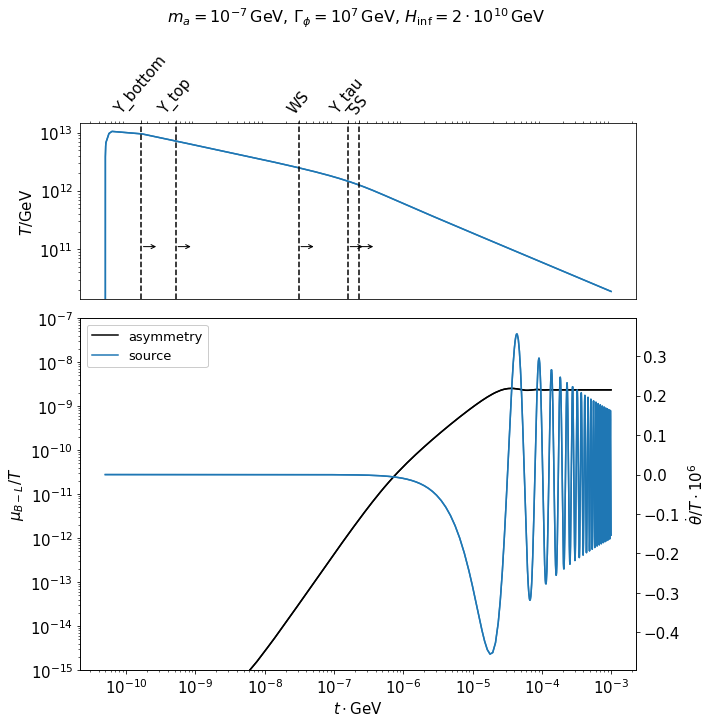

(AxionBaryogenesisModel(source_vector=array([1, 0, 0, 0, 0, 0, 0]), axion_rhs=<function clock_work_rhs at 0x7fb856bd4160>, calc_axion_mass=<function clock_work_mass at 0x7fb856bd41f0>, axion_parameter=(6, 15.35529353954466), axion_initial=(1, 0), Gamma_phi=10000000.0, H_inf=20000000000.0),
 [Result(t=array([5.00000000e-11, 5.00050003e-11, 5.00100010e-11, 5.00600360e-11,
         5.01101211e-11, 5.06137362e-11, 5.11224127e-11, 5.64990038e-11,
         6.24410559e-11, 1.69732387e-10, 4.61380465e-10, 8.14138957e-10,
         1.43660665e-09, 1.89184986e-09, 2.49135412e-09, 5.48273804e-09,
         7.71904424e-09, 1.08674979e-08, 1.39829232e-08, 1.79914588e-08,
         2.11576992e-08, 2.48811527e-08, 2.92598811e-08, 3.58859727e-08,
         4.40125863e-08, 5.39795247e-08, 6.28356340e-08, 7.31447141e-08,
         8.51451456e-08, 9.50583153e-08, 1.06125643e-07, 1.18481503e-07,
         1.32275915e-07, 1.49174072e-07, 1.68230958e-07, 1.89722347e-07,
         2.13959246e-07, 2.41292393e-07, 2.

In [30]:
clockwork(mR, M, Gamma_phi, H_inf, t_end=1e-3)

In [19]:
"%e" % H_inf

'2.000000e+10'